# Classification Example - MNIST<a class="anchor" id="top"></a>

This notebook was written by following the textbook of  Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, along with associated datasets ([Link to Github Repo](https://github.com/ageron/handson-ml/)). The contents in this notebook are my notes from reading the textbook.

### Notebook by Justin Bandoro

In this notebook, we will be working with the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology) dataset. This is a dataset of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. It is a great dataset for classification.

<img src='mnistdigits.gif'>

1. [Framing the problem](#frameproblem)
2. [Loading the data](#getdata)
3. [Checking the data](#checkdata)
4. [Explore the data](#explore)
5. [Training and test sets](#traintest)
6. [Visualize the training data](#visualize)
7. [Feature engineering testing](#featureng)
8. [Data preperation](#preperation)
9. [Transformer pipelines](#pipelines)
10. [Select and Train a Model](#firstmodels)
11. [Model baselines](#baselines)
12. [Fine-tuning hyperparameters](#gridsearch)
13. [Analyzing the best estimators](#bestestimators)
14. [Evaluate system on test data](#evaluatetesth)
14. [Summary](#summary)

## Framing the problem <a class="anchor" id="frameproblem"></a>

[[back to top]](#top)

The task at hand is to construct a model of housing prices in California using the California census data which contains features such as population, median income, median housing price, etc. for each district in California. The objective is to predict the median housing price in any district givien all other metrics

We can define the problem in terms of how would a business expect to benefit from a model we construct:

*"The business you are working for will use model output as part of a larger project that will use output into another machine learning system to determine if it is worth investing in the area or not. District pricing from the model you construct will be a critical piece!"*

#### What is the current solution?

Good idea to get reference performance, and how to solve problem. The business says that district housing prices are estimated by experts, where they gather information and use complex rules to get an estimate with a typical error of 15%.

#### What type of problem is it?

This is a supervised learning problem since the dataset has known labels (median housing price). It is also a multivariate regression problem since we'll have to predict a value from multiple features/attributes. There is no incoming data to update our model, and the data is small enough to fit into memory so can use batch learning.

#### What performance metric should be used?

The most common scoring metric for regression problems is the RMSE, which is standard deviation of errors the system makes in the predictions. E.g. an RMSE of `$`50,000 means 68`%` of the predictions fall within `$`50,000 of the actual value, and 95`%` within `$`100,000. RMSE is the cost function we want to minimize. Though if we find there are many outliers we may want to use the Mean Absolute Error

## Loading the data <a class="anchor" id="getdata"></a>

[[back to top]](#top)

Load workspace and import the data.

In [1]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio

pd.set_option('precision',1) #easy to read output

# Load data 
# Uncomment below if you want to fetch it from sklearn, it is provided in directory
# as 'mnist-original.mat 
## from sklearn.datasets import fetch_mldata
## mnist = fetch_mldata('MNIST original')
import scipy.io as sio
mnist = sio.loadmat('mnist-original.mat')
mnist.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mldata_descr_ordering', 'data', 'label'])

We can then get our dataset, `X`, and the labels associated with it, `y`.

In [2]:
# Load dataset and target labels
X,y = mnist['data'],mnist['label']
# reshape X so rows are instances
X = X.T
y = y.T[:,0]
print('X shape:',X.shape)
print('y shape:', y.shape)

X shape: (70000, 784)
y shape: (70000,)


There are 70,000 images in the dataset, and each image has 784 features. Each feature corresponds to a pixel's intensity in a 28x28 pixel image. The intensity ranges from 0 (white) to 255 (black).

## Visualize the data

Let's load random 25 images, and put the corresponding label with it.

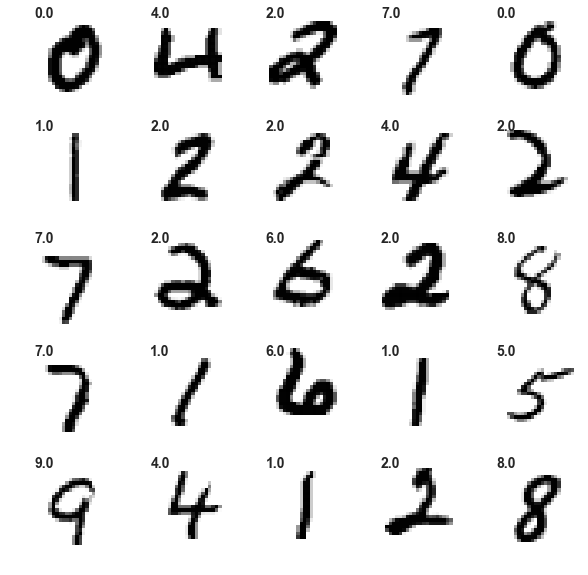

In [3]:
# Plot the a random set of 25 images from the dataset along with the labels
fig,axes = plt.subplots(5,5,figsize=[10,10])
randints = np.random.randint(0,70000, size=25)
for ax,rand in zip(axes.ravel(),randints):
    digit = X[rand,:]; label = y[rand]
    digit_image = digit.reshape(28,28)
    ax.imshow(digit_image,cmap=matplotlib.cm.binary,interpolation='nearest')
    ax.axis('off')
    ax.text(0.1, 0.9,label,transform = ax.transAxes,size=14,weight='bold')


## Training and test splitting

The MNIST dataset is already split into a training set with the first 60,000 images and a test set with the last 10,000 images. We'll also shuffle the training set since it is ordered by digits 0-9.

In [5]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

np.random.seed(42)
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]

# We'll also take a subset of training and testing for quick computing, they are already shuffled
subset=0.1
Nsubs = int( subset*len(y_train) )
X_train_sub = X_train[:Nsubs]; y_train_sub=y_train[:Nsubs]

Now we have training and test datasets with separate features/labels. We'll begin with training a binary classifier.

## Training a Binary Classifier

We can start simple and train a model to predict whether a digit image is a specified digit or not. For example let's use the number 5. The classifier will distinguish between only two classes, 5 or not-5. 

First we have to create new labels that are True or False if the label is a 5. Then we will use a *Stochastic Gradient Descent* (SGD) classifier which has the advantage of handling very large datasets efficiently. Due to the fact that it deals with training instances independently, which also makes it suitable for online learning.

In [6]:
def plot_digit(data,ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,figsize=[4,4])
    image = data.reshape(28, 28)
    ax.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    ax.axis("off")
    
def plot_digits(instances, images_per_row=10,ax=None, **options):
    if ax is None:
        fig,ax=plt.subplots(1,figsize=[6,6])
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    ax.imshow(image, cmap = matplotlib.cm.binary, **options)
    ax.axis("off")

In [9]:
from sklearn.linear_model import SGDClassifier

# Change to binary classification 
y_train_5 = (y_train==5)
y_test_5  = (y_test==5)

# Create SGD classifier
sgd_clf = SGDClassifier(random_state=42) #for reproducible results
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

Let us quickly apply the classifier to a training instance and see what it does:

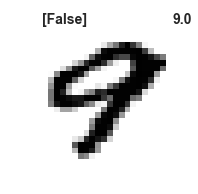

In [20]:
# Grab an instance
some_digit=X_train[855,:] 
# Predict using classifier
label = sgd_clf.predict([some_digit])
fig,ax=plt.subplots(1,1,figsize=[3,3])
ax.imshow(some_digit.reshape(28,28),cmap=matplotlib.cm.binary,interpolation='nearest')
ax.axis('off')
ax.text(0.1, 0.9,label,transform = ax.transAxes,size=14,weight='bold')
ax.text(0.9, 0.9,y_train[855],transform = ax.transAxes,size=14,weight='bold')

Can see from the above that it correctly classified the digit as non-5. Now let's evaluate the performance.

## Classification Performance Measures

Evaluating a classifier is not as straight-forward as evaluating a regressor. We'll touch on them in this section.

### Accuracy with Cross-Validation

Here we will look at cross-validation reported accuracy implementing it ourselves. The `StratifiedKFold` tool allows stratified sampling to preserve the percentage of samples for each class so that each set/fold contains approximately the same percentage of samples of each target class as the complete set.

In [11]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score

kfolds = StratifiedKFold(n_splits=3, random_state=42)

scores=[]
for train_index,test_index in kfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds  = X_train[test_index]
    y_test_folds  = y_train_5[test_index]
    # Train model and predict 
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    # Accuracy
    accuracy = accuracy_score(y_test_folds, y_pred)
    scores.append(accuracy)
    
print('Stratified KFold C-V accuracy scores:',scores)

Stratified KFold C-V accuracy scores: [0.95020000000000004, 0.96565000000000001, 0.96494999999999997]


Can see from the above that the accuracy scores look to be quite high over 95% success rate. Let's repeat the above but without stratifying the cross-validation folds:

In [12]:
# Kfold C-V
scores = cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')
print("KFold C-V accuracy scores:",scores)

KFold C-V accuracy scores: [ 0.9502   0.96565  0.96495]


This looks to be good until we realize that there are 9 other digits besides 5 so it might not be that impressive that it is acheiving high accuracy. We can quickly make our own classifier that classifies all instances as non-5, and then look at it's accuracy:

In [33]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

# C-V with classifier
scores = cross_val_score(Never5Classifier(),X_train,y_train_5,cv=3,scoring='accuracy')
print("Never classify 5 KFold C-V accuracy scores:",scores)

Never classify 5 KFold C-V accuracy scores: [ 0.91195  0.90665  0.91035]


As we mentioned above it has over 90% accuracy because only 10% of the samples in dataset are 5s. Shows that accuracy is not the best metric when we're dealing with skewed datasets.

### Confusion Matrix

A better way to evaluate the performance of a classifier is to examine the *confusion matrix* which shows the counts of correct and incorrect classification. It can reveal what is confusing (no pun intended) the classifier, for exmaple if it is confusing 5s with 8s or 3s you would be able to see this.

For this exercise we will use the `cross_val_predict` function which does so by majority vote. First we will introduce a utility to visualize the confusion matrix.

In [13]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues,
                         std=None,ax=None,fig=None,colorbar=True,text=True,
                         errors=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax is None:
        fig,ax = plt.subplots(1,figsize=[6,6])
        

    if normalize:
        cmsum = cm.sum(axis=1)
        cm = cm.astype('float') / cmsum[:, np.newaxis]
#        std = std.astype('float')/cmsum[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#    print(cm)
    if errors:
        di = np.diag_indices(len(classes))
        cm[di] = 0
        
    cs=ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    if colorbar:
        fig.colorbar(cs)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks);ax.set_xticklabels( classes, rotation=45)
    ax.set_yticks(tick_marks);ax.set_yticklabels( classes, rotation=45)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if std is None and text:
            ax.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        elif text:
            ax.text(j, i, '{:0.2f} ({:0.2f})'.format(cm[i, j],std[i,j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

Confusion matrix, without normalization


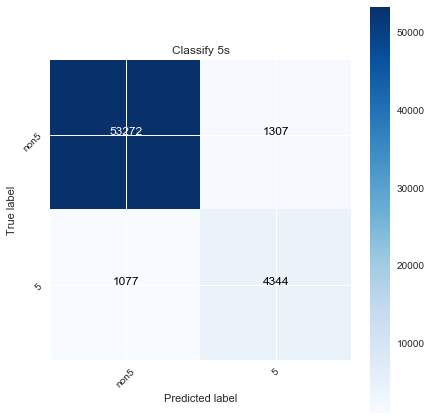

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Get predictions 
y_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
confmat= confusion_matrix(y_train_5,y_pred)

# Plot confusion matrix
plot_confusion_matrix(confmat, ['non5','5'], normalize=False,title='Classify 5s')

The first row considers non5 digits (negative class): 54,000 of them were correctly classified (**true negatives**) while just over 2,400 were incorrectly classified as 5 (**false positives**). The second row considers digits that were 5s (positive class): 930 of them were incorrectly classified as non5 (**false negatives**) and 4,500 were correctly classified as 5s (**true positives**). 

A perfect classifier would have only true positives and true negatives. Let's quickly see what the `Never5Classifier` looks like in the confusion matrix:

Confusion matrix, without normalization


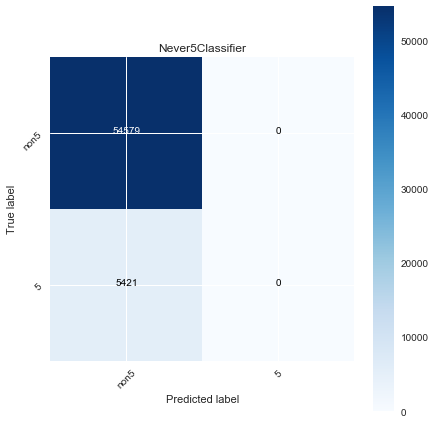

In [36]:
# Get predictions 
y_predn5 = cross_val_predict(Never5Classifier(),X_train,y_train_5,cv=3)
confmat= confusion_matrix(y_train_5,y_predn5)
# Plot confusion matrix
plot_confusion_matrix(confmat, ['non5','5'], title='Never5Classifier',normalize=False)

As we expected it perfectly classifies all non5s (**true negatives**) and incorrectly classifies all 5s (**false negatives**).

The confusion matrix is great for visual representation but it would be nice to have what it represents in a performance metric, this is where **precision** and **recall** come in.

### Precision and Recall

**Precision** is related to the accuracy of the positive predictions and is defined as:

$precision = \frac{TP}{TP+FP}$,

where $TP$ is the number of true positives and $FP$ is the number of false positives.

Alone precision is not that useful since we can imagine an instance where we have to make only 1 positive prediction and it is correct. This is where **recall** also known as *sensitivity* or the *true positive rate* (TPR) comes in. It is the ratio of positive instances that are correctly detected by the classifier:

$recall = \frac{TP}{TP+FN}$,

where $FN$ is the number of false negatives. 

`sklearn` provides metrics for precision and recall built-in that we can use.

In [15]:
from sklearn.metrics import precision_score, recall_score

prec_score = precision_score(y_train_5,y_pred)
rec_score  = recall_score(y_train_5,y_pred)

print('Precision score:',prec_score)
print('Recall score:',rec_score)

Precision score: 0.768713502035
Recall score: 0.801328168235


The above means that when our binary 5 classifier claims a digit is a 5, it is only correct 64% of the time, and it only detects 83% of all 5s.

Now it would be nice if we could have both the precision and recall into a single metric instead of having to look at both of them. We can indeed combine them.

### F$_1$ Score

The **$F_1$ score** is defined as the harmonic mean of the precision and recall. While a standard mean treats all values equally, a harmonic mean gives more weight to the lower values. Thus a classifier will only get a high $F_1$ score if both recall and precision are high. It is calculated by:

$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall} } = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}} $

Let's calculate this for our SGD classifier:

In [28]:
from sklearn.metrics import f1_score

f1score = f1_score(y_train_5,y_pred)
print('F1 score: ',f1score)

F1 score:  0.784682080925


$F_1$ scores favor classifiers that have similar precision and recall. Though this may not be what your classification problem cares about. In some cases you may heavily weight precision or really care about recall.

For instance suppose you trained a classifier that detects if the lyrics of a song are safe for children to listen to. You would rather have a classifier that rejects sometimes good songs (false negatives, low recall) and keeps only good ones (true positives, low false positives, high precision).

On the other hand, if you train a classifier to detect presence of a bomb, it is OK if the classifier has only a low precision as long as it has near 100% recall, with close to zero false negatives. Sure it might get a few false alerts (false positives) but almost all true bombs will get caught.

Unfortunately you can't have it both ways: increasing precision reduces recall and vice versa.

### Precision/Recall Tradeoff

To understand what this tradeoff, we can understand how `SGDClassifier` performs classification. For each instance, a score based on a decision function is computed and if the score is greater than a threshold, it assigns the instance to the positive class, or else it assigns to the negative class. Consider if we had the following predictions where the digits to the left of the `|` are classified as negative (non5s) and those to the right are classified as positive (5s):

                  8 4 2 1 5 2 5 | 5 5 6 5 5 5

The precision is equal to $\frac{5}{5+1}=84\%$ and the recall is equal to $\frac{5}{5+2} = 71\%$ since out of the seven total 5s the classifier only found 5. If the threshold is increased to the right to remove the false positive (6), you end up with more false negatives so the recall will go down. Conversely, lowering the threshold (moving to the left) will decrease the precision. 

For the `SGDClassifier`, we have access to the `decision_function()` method which returns a score for each instance and you can make predictions on them manually since the classifier uses a threshold of 0.

Actual label:  True
Score:  -11176.4611205  prediction:  False
sgd_clf prediction:  [False]


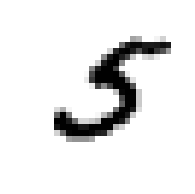

In [25]:
# Grab an instance we know is 5
instance = np.where(y_train_5==True)[0][0]
some_digit = X_train[instance,:] 
some_label = y_train_5[instance]

#Draw what digit looks like
fig,ax=plt.subplots(1,1,figsize=[3,3])
ax.imshow(some_digit.reshape(28,28),cmap=matplotlib.cm.binary,interpolation='nearest')
ax.axis('off')

y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores>threshold)
print('Actual label: ',some_label)
print('Score: ',y_scores[0],' prediction: ',y_some_digit_pred[0])
print('sgd_clf prediction: ',sgd_clf.predict([some_digit])[0])

It returns the same as `predict()` since the threshold is equal to 0, and is misclassifying the 5 as non5. We can try to lower the threshold below -11,000 to see what happens:

In [27]:
threshold = -11500.
y_some_digit_pred = (y_scores>threshold)
print('Score: ',y_scores[0],' prediction: ',y_some_digit_pred[0])

Score:  -11176.4611205  prediction:  True


Lowering the threshold decreases the precision but increases the recall (can get more 5s classified correctly). Conversely, raising the threshold decreases the recall, it misses the digit when the threshold is increase too high. We can quickly show this by using our threshold based predictions from the `decision_function()` and calculate the confusion matrix and associate precision/recall. 

Threshold =  -12000
Precision score: 0.624368255703
Recall score: 0.843202361188
Confusion matrix, without normalization
Threshold =  0
Precision score: 0.646838542417
Recall score: 0.828444936359
Confusion matrix, without normalization
Threshold =  12000
Precision score: 0.66909201152
Recall score: 0.81424091496
Confusion matrix, without normalization


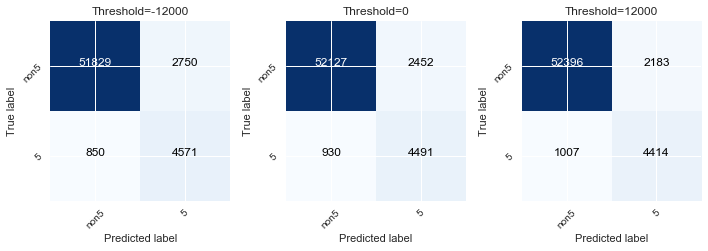

In [51]:
fig,axes = plt.subplots(1,3,figsize=[10,5])
# Return the decision_function result for cross_val_predict
y_scores  = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')
for ax,threshold in zip(axes.ravel(),[-12000,0,12000]):
    y_preds   = (y_scores>threshold) 
    # Calculate precision and recall
    print('Threshold = ',threshold)
    print('Precision score:', precision_score(y_train_5,y_preds))
    print('Recall score:', recall_score(y_train_5,y_preds))
    # Show confusion matrix
    confmat= confusion_matrix(y_train_5,y_preds)
    plot_confusion_matrix(confmat, ['non5','5'], normalize=False,title='Threshold={}'.format(threshold),ax=ax,fig=fig,colorbar=False)

We can confirm above that decreasing the threshold decreases the precision and increases the recall, while increasing the threshold increases the precision but decreases the recall. The middle confusion matrix with threshold of zero is the same one we had earlier using `cross_val_predict`. 

We can determine which threshold value is optimal by plotting the `precision_recall_curve` using the `decision_function` output we computed above for all the instances.

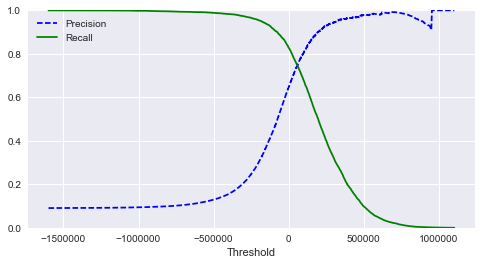

In [53]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

#Function to plot the results
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.figure(figsize=[8,4])
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
    plt.xlabel("Threshold")
    plt.legend(loc='upper left');plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

From a figure like the one above you can select the precision/recall tradeoff needed for the problem at hand. Another way to plot is to show precision vs recall on a single plot.

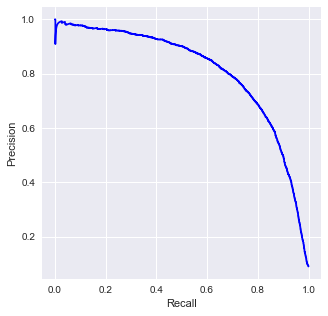

In [55]:
# Plot recall vs precision
fig,ax=plt.subplots(1,figsize=[5,5])
ax.plot(recalls,precisions,'b')
ax.set_xlabel('Recall');ax.set_ylabel('Precision')

Can see that precision falls off rapidly after a recall of around 85%. Imagine you wanted a precision of 90% for the project, from the previous two figures you need a threshold of around 70,000.

### The ROC Curve

The *receiver operating characteristic* (ROC) curve is another tool used to analyze performance of binary classifiers. It is similar to the precision/recall curve above, but instead plots the *true positive rate* (recall) against the *false positive rate* (FPR). FPR is the ratio of negative instances that are incorrectly classified as positive, and is equal to 1 minus the *true negative rate* (TNR). 

$FPR = 1 - TNR = 1 -  \frac{TN}{TN+FP}$

The TNR is often called the *specificity* which is the ratio of negative instances that are correctly classified as negative.

To plot the ROC curve you need to calculate the TPR and FPR for the various threshold values. `sklearn` has a built in function to do this called `roc_curve`.

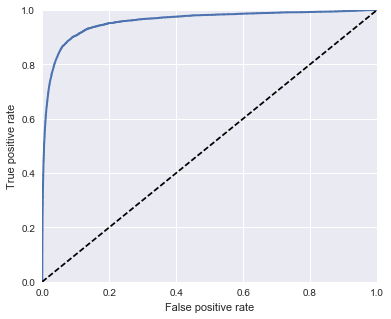

In [59]:
from sklearn.metrics import roc_curve

fpr,tpr, thresholds = roc_curve(y_train_5,y_scores)
# Plot ROC curve
def plot_roc_curve(fpr,tpr,label=None,ax=None):
    if ax is None:
        fig,ax=plt.subplots(1,figsize=[6,5])
    ax.plot(fpr,tpr,lw=2,label=label)
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([0,1]);ax.set_ylim([0,1])
    ax.set_xlabel('False positive rate');ax.set_ylabel('True positive rate')

plot_roc_curve(fpr,tpr)

We can see the tradeoff in the plot above, the higher the recall (TPR) the more false positives (FPR) the classifier produces. The dashed line signifies a purely random classifier; a good classifier stays away in the top-left corner.

**When to use ROC vs P/R curves**: we can compare the ROC curve above to the P/R curve before. You should prefer the P/R curve when the positive class is rare (like our 5s in this example) or if you care more about the false positives than the false negatives. For example above, the ROC curve looks good but this is because there are few positives (5s) compared to negatives (non-5s). 

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to unity, whereas a purely random classifier will have a ROC AUC equal to 0.5. `sklearn` has a function to compute the ROC AUC:

In [60]:
from sklearn.metrics import roc_auc_score
print('ROC AUC score: ', roc_auc_score(y_train_5,y_scores))

ROC AUC score:  0.958596097047


Next let's train a `RandomForestClassifier` and compare the reported ROC and ROC AUC score to our `SGDClassifier`. As we saw earlier for the `SGDClassifier` we could get the decision functions, but `RandomForestClassifier` does not have this method, instead we will use the `predict_proba()` method. All `sklearn` classifiers either have one or the other.

The `predict_proba()` returns an array containing a row per instance and a column per class, each containing the probability that a given instance belongs to the given class (i.e. 70% chance the digit is a 5).

Random Forest ROC AUC score: 0.992496776292
Random Forest Precision score: 0.985906188064
Random Forest Recall score: 0.825862387013


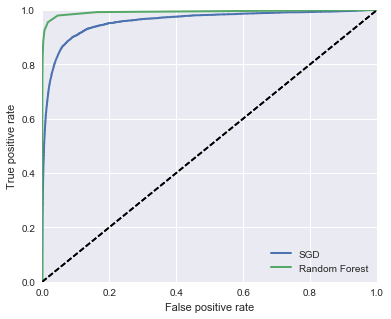

In [67]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf      = RandomForestClassifier(random_state=42)
y_probas_rf = cross_val_predict(rf_clf,X_train,y_train_5,cv=3,method='predict_proba')
y_preds_rf  = cross_val_predict(rf_clf,X_train,y_train_5,cv=3)

# To plot ROC need scores not probabilities, so we can use the positive
# class probability for the score
y_scores_rf = y_probas_rf[:,1] # probability of positive class

# Calculate ROC
fpr_rf,tpr_rf,thresholds_rf = roc_curve(y_train_5,y_scores_rf)

# Plot compared to SGD
fig,ax = plt.subplots(1,figsize=[6,5])
plot_roc_curve(fpr,tpr,label='SGD',ax=ax)
plot_roc_curve(fpr_rf,tpr_rf,label='Random Forest',ax=ax)
ax.legend(loc='lower right')

# Calculate ROC AUC score 
print('Random Forest ROC AUC score:', roc_auc_score(y_train_5,y_scores_rf))
# Precision and recall scores
print('Random Forest Precision score:', precision_score(y_train_5,y_preds_rf))
print('Random Forest Recall score:', recall_score(y_train_5,y_preds_rf))

Can see that the precision is much higher for the Random Forest vs the SGD classifier, and the ROC curve looks better being closer to the top left.

## Multiclass Classification 

Multiclass classifiers can distinguish between more than two classes. Some algorithms can deal with multiple classes directly such as Random Forest or naive Bayes. Others are strictly binary classifiers, like Support Vector Machine or Linear classifiers, but there are strategies to perform multiclass classification using multiple binary classifiers.

For example we can take our previous binary classifier but repeat it so that each digit from 0 to 9 has a binary classifier. Then when we want to classify an image we can take the decision score from each classifier and select the class whose classifier has the highest score. This is called the **one-vs.-the-rest**. Another strategy is to train binary classifiers to distinguish between pair of digits: i.e. one to distinguish between 0s and 1s and another to distinguish between 0s and 2s. This is called **one-vs.-one** strategy. If there are $N$ classes you have to train $N \times (N-1)/2$ classifiers. Although it is more classifiers, each classifier only has to be trained on part of the training set that contains the two classes.

Support Vector Machine classifiers scale poorly with size of the training set, so the one-vs-one approach is preferred since it is faster to train many classifiers on small training sets than a few on a large training set. `sklearn` detects when you try to use binary classification on multiclass problems and automatically runs one-vs.-all (except for SVM).

We will test out the `SGDClassifier` first.

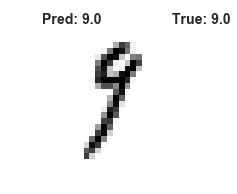

In [69]:
# Train classifier on all class labels
sgd_clf.fit(X_train,y_train)
# Grab an instance to test and plot results
some_digit=X_train[3453,:] 
# Predict using classifier
label = sgd_clf.predict([some_digit])
fig,ax=plt.subplots(1,1,figsize=[3,3])
ax.imshow(some_digit.reshape(28,28),cmap=matplotlib.cm.binary,interpolation='nearest')
ax.axis('off')
ax.text(0.1, 0.9,'Pred: {}'.format(label[0]),transform = ax.transAxes,size=14,weight='bold')
ax.text(0.9, 0.9,'True: {}'.format(y_train[3453]),transform = ax.transAxes,size=14,weight='bold')

We can see that the classifier correctly predicted the digit. Since behind the scenes, `sklearn` creates 10 binary classifiers and compared their decision scores for the image instance and selected the highest one. We can look at the decision function:

In [74]:
#Output decision function for instance
out = sgd_clf.decision_function([some_digit])
# Create pandas series ranking the scores
scores = pd.DataFrame(out.T,index=sgd_clf.classes_)
scores.sort_values(0,ascending=False)

,0
9.0,104980.3
3.0,50767.2
7.0,-23158.2
1.0,-57813.7
4.0,-203706.6
5.0,-281979.8
8.0,-284254.9
2.0,-327401.6
6.0,-461772.3
0.0,-571697.3


We can see that the digit that was correctly classified (9) has the highest decision score of all 10 digits.

For the one-vs.-one strategy we can force `sklearn` to perform it by using the `OneVsRestClassifier`:

Number of estimators in OvO:  45


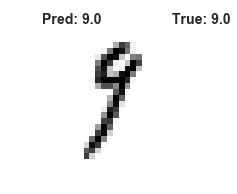

In [78]:
from sklearn.multiclass import OneVsOneClassifier

#Train one-vs-one classifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
#Output number of estimators
print('Number of estimators in OvO: ',len(ovo_clf.estimators_))
# Predict using classifier
label = ovo_clf.predict([some_digit])
fig,ax=plt.subplots(1,1,figsize=[3,3])
ax.imshow(some_digit.reshape(28,28),cmap=matplotlib.cm.binary,interpolation='nearest')
ax.axis('off')
ax.text(0.1, 0.9,'Pred: {}'.format(label[0]),transform = ax.transAxes,size=14,weight='bold')
ax.text(0.9, 0.9,'True: {}'.format(y_train[3453]),transform = ax.transAxes,size=14,weight='bold')

We can see that is also predicted correctly our test instance.

Next we'll train a `RandomForestClasifier`:

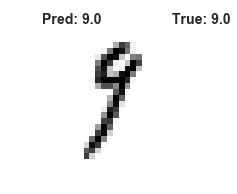

In [79]:
# Train random forest classifier
rf_clf.fit(X_train,y_train)
# Predict using classifier
label = rf_clf.predict([some_digit])
fig,ax=plt.subplots(1,1,figsize=[3,3])
ax.imshow(some_digit.reshape(28,28),cmap=matplotlib.cm.binary,interpolation='nearest')
ax.axis('off')
ax.text(0.1, 0.9,'Pred: {}'.format(label[0]),transform = ax.transAxes,size=14,weight='bold')
ax.text(0.9, 0.9,'True: {}'.format(y_train[3453]),transform = ax.transAxes,size=14,weight='bold')

Furthermore since `RandomForestClassifier` does not use OvA or OvO strategies, we can get the probability through `predict_proba()` that the classifier assigned to each class for each instance:

In [80]:
#Output decision function for instance
out = rf_clf.predict_proba([some_digit])
# Create pandas series ranking the scores
scores = pd.DataFrame(out.T,index=rf_clf.classes_)
scores.sort_values(0,ascending=False)

,0
9.0,0.8
7.0,0.2
0.0,0.0
1.0,0.0
2.0,0.0
3.0,0.0
4.0,0.0
5.0,0.0
6.0,0.0
8.0,0.0


The Random Forest classifier estimated that with 80% probability the digit is a 9 and 20% is a 7.

We can then evaluate the classifiers using cross-validation, and it is the same as we did before:

In [82]:
#C-V of classifiers
print('3fold C-V accuracy using SGD: ', cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy'))
print('3fold C-V accuracy using RF : ', cross_val_score(rf_clf, X_train,y_train,cv=3,scoring='accuracy'))

3fold C-V accuracy using SGD:  [ 0.88232354  0.83924196  0.82682402]
3fold C-V accuracy using RF :  [ 0.94111178  0.94154708  0.94429164]


SGD and RF get 84 and 94% accuracy on all test folds respectively. If we were to use a random classifier we would only achieve 10% accuracy. We can perform some data-preprocessing and hyperparameter tuning to improve the accuracy. For example, scaling is not important in Random Forests but for SGD it can make a difference.

Before we try to tune the complex Random Forest classifier, which will be more computing resources depending on the number of estimators we use, let's try to do the best we can with the SGD Classifier. Since it is a linear model, we can scale the input first.

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()

sgd_pipeline = Pipeline([ ('scaler', scaler ),
                          ('clf', SGDClassifier(random_state=42) )
                        ])

# C-V 
print('3fold C-V accuracy using SGD with scaled inputs: ', cross_val_score(sgd_pipeline,X_train,y_train,cv=3,scoring='accuracy'))

NameError: name 'sgd_pipeline' is not defined

### Tuning with Random Forests

In [91]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def report(results, n_top=3,rmse=False):
    # if RMSE is true will take square root
    exp=0.5 if rmse else 1.0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  (results['mean_test_score'][candidate])**exp,
                  (results['std_test_score'][candidate])**exp  ))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


param_grid = {'n_estimators': randint(10,300),
              'max_depth'   : randint(1,30),
              'max_features': ['log2','sqrt',None] 
             }      
gs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),param_grid,n_iter=20,cv=3,scoring='accuracy',n_jobs=-1)
gs_rf.fit(X_train,y_train)
#Print scores
rf_results =  gs_rf.cv_results_
report(rf_results)

Model with rank: 1
Mean validation score: -0.967 (std: 0.001)
Parameters: {'max_depth': 21, 'max_features': 'sqrt', 'n_estimators': 294}

Model with rank: 2
Mean validation score: -0.965 (std: 0.001)
Parameters: {'max_depth': 27, 'max_features': 'log2', 'n_estimators': 283}

Model with rank: 3
Mean validation score: -0.964 (std: 0.001)
Parameters: {'max_depth': 24, 'max_features': 'log2', 'n_estimators': 166}



AttributeError: 'RandomForestClassifier' object has no attribute 'steps'

So with the tuning above we were able to find the hyperparameters for the `RandomForestClassifier` that increase the accuracy to around 97%. Let's check to see what the accuracy is on the whole training set. While we shouldn't look at test data performance as that might influence model selection and tuning, we'll evaluate to see how high an accuracy we get on unseen data.

In [95]:
y_rf_tuned_pred = gs_rf.predict(X_train)
print('Tuned RF accuracy score for training set: ',accuracy_score(y_train,y_rf_tuned_pred))
y_rf_tuned_pred = gs_rf.predict(X_test)
print('Tuned RF accuracy score for test set: ',accuracy_score(y_test,y_rf_tuned_pred))

Tuned RF accuracy score for training set:  0.999516666667
Tuned RF accuracy score for test set:  0.9704


With hyperparameter tuning we were able to find a Random Forest Classifier that achieves over 97% on the test data.

Let's save the grid search best estimator so we don't have to go through the process over and over.

In [96]:
from sklearn.externals import joblib
rf_tuned_clf = gs_rf.best_estimator_
joblib.dump(rf_tuned_clf, 'rf_tuned_clf.pkl') 

['rf_tuned_clf.pkl']

In [20]:
from sklearn.externals import joblib
rf_tuned_clf =joblib.load('rf_tuned_clf.pkl') 

### K-Nearest Neighbor Classifier

Let's also try this classifier on the data to see if it can get a better

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=4,weights='distance')
knn_clf.fit(X_train,y_train)

y_knn_pred = knn_clf.predict(X_train)
print('KNN accuracy score for training set: ',accuracy_score(y_train,y_knn_pred))
y_knn_tuned_pred = knn_clf.predict(X_test)
print('KNN accuracy score for test set: ',accuracy_score(y_test,y_knn_pred))

## Error Analysis

One way to improve a model is to analyze the type of errors it makes. The confusion matrix we introduced earlier is a good way to do this. Let's look at our predictions from the tuned Random Forest model we found.

Confusion matrix, without normalization


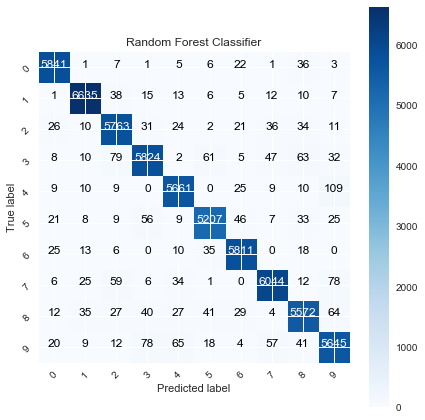

In [21]:
y_train_pred = cross_val_predict(rf_tuned_clf,X_train,y_train,cv=3)
confmat = confusion_matrix(y_train,y_train_pred)
classes = [str(n) for n in range(0,10)]
plot_confusion_matrix(confmat,classes, title='Random Forest Classifier',normalize=False)

It's good that the diagonals are the darkest blue, with the digit 1 seeming to be the darkest. This could be because there are more images of 1 in the dataset or the classifier is really good at finding 1s. 

This is hard to see in the above, so lets normalize the confusion matrix. And also replace diagonals with zeros so it's easier to see the errors.


Normalized confusion matrix
errors


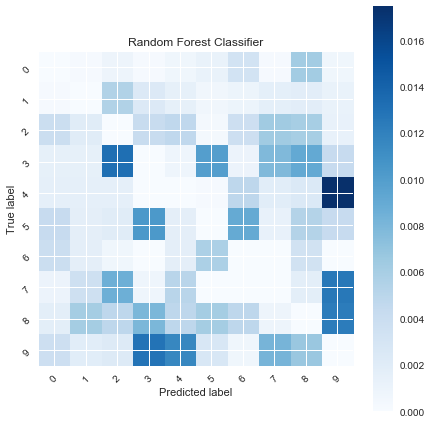

In [59]:
plot_confusion_matrix(confmat,classes, title='Random Forest Classifier',normalize=True,text=False,
                      errors=True)

With the diagonals removed we can see where the errors in classification are. For example we see that one of the highest error rates is for 4 to be classified as 9 and 3 misclassified as 2. The dark rows also tell us which digits are classified the best and the worst. The 0 and 1 rows are lightly shaded while 3 and 9 are darker and classified the least well. 

Efforts can be spent on improving classification of 3s, 4s and 9s, for example you could gather more training data for these digits. Or we could engineer new features that count the number of closed loops (two for 8, one for 9). We could also preprocess the images to make some patterns stand out more like closed loops.

Let's plot samples of the 4s and 9s that correctly and incorrectly classified:

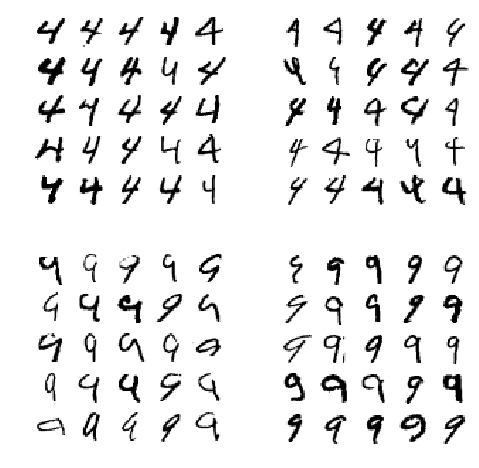

In [62]:
#Find examples of correctly and incorrectly classified digits a and b
cl_a=4;cl_b=9
X_aa = X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

#Make plots
fig,(axes) = plt.subplots(2,2,figsize=[8,8])
plot_digits(X_aa[:25],images_per_row=5,ax=axes[0,0])
plot_digits(X_ab[:25],images_per_row=5,ax=axes[0,1])
plot_digits(X_ba[:25],images_per_row=5,ax=axes[1,0])
plot_digits(X_bb[:25],images_per_row=5,ax=axes[1,1])

The diagonals show images that are classified correctly, while the top right shows true 4s that are misclassified as 9s and the bottom left shows 9s that are misclassified as 4s. It seems like whether the 4 is open at the or closed plays a role and also if the 9 is properly looped and closed is important.

Another part could be that the classifier is sensitive to image shifting and rotation. In the bottom left lots of the 9s are rotated so that they may look like 4s. Below we will implement data preparation to add extra features that also include the image shifted up, down, left, or right by one pixel. We will also add a rotate option as well.





NameError: name 'some_digit' is not defined

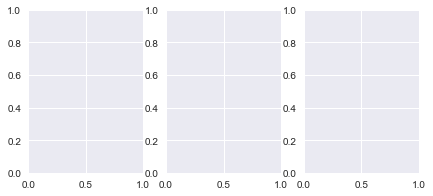

In [28]:
from scipy.ndimage.interpolation import shift,rotate
import cv2 # for rotation

# Shift image pixels horizontally (dx) and vertically (dy)
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

# Shift image pixels horizontally (dx) and vertically (dy)
def rotate_digit(digit_array, dtheta, new=0):
    digit_im = digit_array.reshape(28, 28)
    # grab the dimensions of the image and calculate the center
    # of the image
    (h, w) = digit_im.shape[:2]
    center = (w / 2, h / 2)
    # rotate the image by dtheta degrees
    M = cv2.getRotationMatrix2D(center, dtheta, 1.0)
    rotated = cv2.warpAffine(digit_im, M, (w, h))
    return rotated.reshape(784)

# Test shifting by 5 pixels and rotating by 45 degrees
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=[7,3])
plot_digit( some_digit,ax=ax1); ax1.set_title('Original')
plot_digit( shift_digit(some_digit, 10, 1,),ax=ax2); ax2.set_title('Shifted')
plot_digit( rotate_digit(some_digit,-45),ax=ax3); ax3.set_title('Rotated')

We've shown above we can shift the original digit and also rotate them as well. Next we'll shift up, down, left and right by 1 pixel and also rotate by 15 degrees in each direction.


In [29]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]


for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

for dtheta in [-15,15]:
    rotated_images = np.apply_along_axis(rotate_digit, axis=1, arr=X_train, dtheta=dtheta)
    X_train_expanded.append(rotated_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape 

((420000, 784), (420000,))

Let's first try testing it on the SGD Classifier 

In [30]:
sgd_pipeline.fit(X_train_expanded,y_train_expanded)

#rf_tuned_clf.fit(X_train_expanded,y_train_expanded)

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))])

In [34]:
y_test_pred_sgd = sgd_pipeline.predict(X_test)
y_train_pred_sgd = sgd_pipeline.predict(X_train)

print('SGD on training set with shifted/rotated: ',accuracy_score(y_train,y_train_pred_sgd))
print('SGD on test set with shifted/rotated: ',accuracy_score(y_test,y_test_pred_sgd))

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


SGD on training set with shifted/scaled:  0.91015
SGD on test set with shifted/scaled:  0.9126


Now let's update the random forest classifier with the expanded training set:

In [35]:
rf_tuned_clf.fit(X_train_expanded,y_train_expanded)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=294, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [36]:
y_test_pred_rfexp = rf_tuned_clf.predict(X_test)
y_train_pred_rfexp = rf_tuned_clf.predict(X_train)

print('RF on training set with shifted/rotated: ',accuracy_score(y_train,y_train_pred_rfexp))
print('RF on test set with shifted/rotated: ',accuracy_score(y_test,y_test_pred_rfexp))

RF on training set with shifted/scaled:  0.9982
RF on test set with shifted/scaled:  0.9799


Can see that with adding the shifted and rotated digits we can get the Random Forest classifier up to 98% accuracy on the test sets. We can probably get higher if we used a larger number of estimators but we don't want to incur such high computing costs in this exercise. 

## Multilabel Classification

In some problems you would like multiple classes associated with a single instance. An example is facial recognition where if a photo contains multiple people, and the training set has the following people: Alice, Bob, and Charlie, then you would like the output of a photo with only Bob to be [0,1,0]. 

We can consider examples with the MNIST training set where we want to output if a digit is greater than 7 and if the digit is odd, using `KNeighborsClassifier` which support multilabel classification:

In [19]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train%2==1)
# combine labels
y_multilabel = np.c_[y_train_large,y_train_odd]

# Fit KNN classifier
knn_pipe = Pipeline( [ ('scaler', StandardScaler()), ('knn',KNeighborsClassifier()) ] )

knn_pipe.fit(X_train,y_multilabel)

/Users/Justin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

Let's test it out on our test digit:

Prediction that digit is >= 7 : True
Prediction that digit is odd:  True


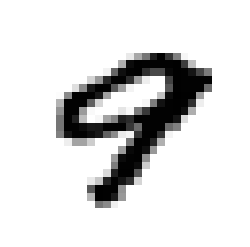

In [26]:
# Plot test digit
plot_digit(some_digit)
# Make predictions
pred = knn_pipe.predict([some_digit])
print('Prediction that digit is >= 7 :',pred[0][0])
print('Prediction that digit is odd: ', pred[0][1])

We can see that the prediction for both labels for the test digit is correct. 

For multilabel classification scoring metrics, we could measure the $F_1$ score for each individual label (or any other binary classifier metric) then compute the average score. This assumes that all labels are equally important, which may not be the case.

In [29]:
y_multi_pred = cross_val_predict(knn_pipe,X_train,y_multilabel,cv=3)
# Calculate F1score average over labels
f1score = f1_score(y_multilabel,y_multi_pred,average='macro')
print('F1 score average over labels: ',f1score)


F1 score average over labels:  0.961903993305


If you have many more instances with Alice than of either Bob and Charlie, you would want to give more weight to the classifier's score on pictures of Alice. A solution is to give each label a weight equal to its support (the number of instances with the target label). Can do this by setting `average='weighted'` in the $F_1$ scorer function.

## Multioutput Classification

This type of classification is a step beyond the last section with multi-class classification where the labels can have more than two possible values.

In this example we will build a multioutput classifier that removes noise form images. It will take as input a noisy digit imaage, and output a clean digit. The output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity from 0 to 255).

We begin by taking the training and test sets and adding noise to the pixel intensities. The target images are now the original images:

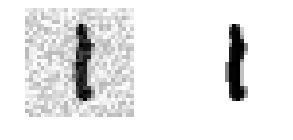

In [34]:
# Make noise
noise_train = np.random.randint(0,100,(len(X_train),784))
noise_test  = np.random.randint(0,100,(len(X_test),784) )
# Add noise to training and test sets
X_train_noise = X_train + noise_train
X_test_noise  = X_test + noise_test
# Targets are previous original digits
y_train_noise = X_train
y_test_noise  = X_test

# Plot noisy and true digit
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[5,2])
plot_digit(X_test_noise[1500],ax=ax1)
plot_digit(y_test_noise[1500],ax=ax2)

Let's train a classifier and see if it cleans the image correctly:

/Users/Justin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


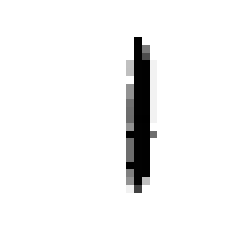

In [36]:
knn_pipe.fit(X_train_noise,y_train_noise)
clean_digit = knn_pipe.predict([X_test_noise[1500]])
plot_digit(clean_digit)

We can see that the cleaned image looks close enough like our target.

## License

The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/).